# Assignment 1


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

Using TensorFlow backend.
C:\Users\thoma\Anaconda3\envs\recomsys\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [3]:
#create co-occurrence matrix
#print(tokenizer)
#print(corpus)
#print(nb_samples)
#print(V)
#print("\n")

def create_co_occurrence(crps, win_size, voc_size):
    # Discuss -1 with Thijs
    co_occurrence_mat = np.zeros((voc_size-1,voc_size-1), int)
    for sentence in crps:
        # Sliding window inside of sentence
        for i, center_word in enumerate(sentence):
            i_min = max(0, i - win_size + 1)
            i_max = min(len(sentence), i + win_size)
            window = sentence[i_min: i_max]
            #print("Window:", window)
            
            # Increment co occurence of words in sliding window
            for j in range(i_min, i_max):
                if i != j:
                    co_word = sentence[j]
                    co_occurrence_mat[center_word-1, co_word-1] += 1
    
    np.amax(co_occurrence_mat)
    
    return co_occurrence_mat

co_occurence = create_co_occurrence(corpus, window_size, V)

#Normalize
co_occurence = co_occurence / np.amax(co_occurence)
co_occurence

array([[ 0.        ,  0.44444444,  0.48148148, ...,  0.03703704,
         0.        ,  0.        ],
       [ 0.44444444,  0.        ,  0.07407407, ...,  0.03703704,
         0.        ,  0.        ],
       [ 0.48148148,  0.07407407,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.03703704,  0.03703704,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [4]:
#find cosine similarity to Alice, Dinah and Rabbit
from scipy import spatial
#print(tokenizer.word_index)

def cosine_sim(word_1, word_2, tknzr, matrix):
    word_1_ind = tknzr.word_index[word_1]
    word_2_ind = tknzr.word_index[word_2]
    
    #print(word_1, word_1_ind)
    #print(word_2, word_2_ind)
    
    word_1_vec = matrix[:,word_1_ind-1]
    word_2_vec = matrix[:,word_2_ind-1]
    
    #print(word_1_vec)
    #print(word_2_vec)
    
    similarity = 1 - spatial.distance.cosine(word_1_vec, word_2_vec)
    #print(similarity)
    
    return similarity
    
    
print('similarity of Alice and Dinah', str(cosine_sim("alice", "dinah", tokenizer, co_occurence)))
print('similarity of Alice and Rabbit', str(cosine_sim("alice", "rabbit", tokenizer, co_occurence)))
print('similarity of Dinah and Rabbit', str(cosine_sim("dinah", "rabbit", tokenizer, co_occurence)))


similarity of Alice and Dinah 0.148538649506
similarity of Alice and Rabbit 0.0763040737666
similarity of Dinah and Rabbit 0.0810361063877


In [5]:
#find the closest words to Alice
import pandas as pd

similarities = {i: cosine_sim("alice", i, tokenizer, co_occurence) if "alice"!= i else 0.0 for i in tokenizer.word_index}
pd_similarities = pd.DataFrame(list(similarities.items()), columns=['Word', 'Sim'])

top_5 = pd_similarities.sort_values(['Sim'], ascending=False)[:5]

print("Most similar word:\n", top_5)
#print(similarities)


Most similar word:
         Word       Sim
289     ahem  0.570483
1000     ugh  0.570483
704      she  0.533538
86       say  0.530232
306   listen  0.498760


C:\Users\thoma\Anaconda3\envs\recomsys\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


Discussion of the drawbacks:

One of the major drawbacks of a co-occurence matrix is the fact that the matrix becomes very large in a very short time. In order to compute answers from it one would need a very strong machine. Ofcourse this is doable however, there are more efficient ways to calculate it. Another drawback of using a co-occurence matrix is that quite some memory is needed to be able to store it all in memory. Of course this can be optimalized but still it is quite costly. 

In [6]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = co_occurence
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i-1,:]))))
    f.write("\n")
f.close()

In [149]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [19]:
def generate_data_cbow(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [20]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, activation='softmax'))

In [21]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [22]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)

    print(ite, loss)

0 42308.2811444
1 38594.1970193
2 38767.0419376
3 38867.8861338
4 38929.3537067
5 38976.922761
6 38995.6720477
7 39014.251945
8 39044.3008515
9 39080.0715766


In [24]:
cbow.save('cbow_simple.h5')

In [26]:
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

In [27]:
#get x and y's for data
x,y = generate_data_skipgram(corpus,window_size,V)#save the preprocessed data of Skipgram


In [28]:
f = open('data_skipgram.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [29]:
#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [30]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [31]:
skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [32]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram.train_on_batch(x, y)

    print(ite, loss)

0 42008.0517182
1 38353.1881878
2 38921.1881423
3 39330.0949223
4 39505.6043484
5 39678.1267002
6 39847.5325572
7 40026.978894
8 40211.2500122
9 40398.6335881


In [34]:
skipgram.save('skipgram_simple.h5')

## Activation for the dense layer

As can be seen below we tried several different activation functions as an extra dense layer. After some research online we decided that at least we wanted to test both ELU and ReLU as activation functions. Apart from these two functions we also wanted to try one else which became Sigmoid. Since ELU and ReLU both are quite good with dealing with vanishing gradients we felt like we needed another layer which strong point was not dealing with the vanishing gradient. Even though Sigmoid and Softmax show similarities we wanted to at least try it to make sure that indeed it would not be the best solution. And as can be seen below it indeed was not the best choice as a second dense layer. 

Because we did not know which one would perform best we decided that we would try all three. We put the activation layers in before the Softmax layer since Softmax is usually used as the last layer in the hidden layers of a neural network. This because Softmax normalizes the results while minimizing the cross-entropy/negative likelihood between the predictions and the actual outcome. 

In [5]:
#create CBOW model with additional dense layer        
dcbow = Sequential()
dcbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
dcbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
dcbow.add(Dense(V, activation='elu'))
#dcbow.add(Dense(V, activation='sigmoid'))
#dcbow.add(Dense(V, activation='relu'))
dcbow.add(Dense(V, activation='softmax'))



Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [62]:
#define loss function for CBOW + dense
dcbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [65]:
#train model for CBOW + dense elu activation
for ite in range(10):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size, V):
        loss += dcbow.train_on_batch(x, y)

    print(ite, loss)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This model was trained, but we overwrote the output by accident. The trained model is saves in "dcbow_elu.h5".
# Since training is slow we are not able to redo this
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Important!

0 39850.4765533


KeyboardInterrupt: 

In [25]:
dcbow.save('dcbow_elu.h5')

In [30]:
#train model for CBOW + dense sigmoid activation
for ite in range(10):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size, V):
        loss += dcbow.train_on_batch(x, y)

    print(ite, loss)

0 42573.9224706
1 40779.2916886
2 40212.4141967
3 40963.4117401
4 42315.4382861
5 43557.8121278
6 44557.614516
7 45347.3085792
8 45826.0357494
9 45717.4792516


In [31]:
dcbow.save('dcbow_Sigmoid.h5')

In [34]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_cbow(corpus, window_size, V):
        loss += dcbow.train_on_batch(x, y)

    print(ite, loss)

0 40066.6369147
1 38122.0871696
2 37527.2364669
3 37265.8932388
4 37098.9213078
5 36907.566846
6 36689.9979763
7 36465.4231402
8 36250.071865
9 36031.9165194


In [35]:
dcbow.save('dcbow_Relu.h5')

In [9]:
#create Skipgram with additional dense layer
dskipgram = Sequential()
dskipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
dskipgram.add(Reshape((dim, )))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='elu'))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))


In [10]:
#define loss function for Skipgram + dense
dskipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
#train model for Skipgram + dense
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += dskipgram.train_on_batch(x, y)

    print(ite, loss)

0 39171.4094963
1 37593.4716475
2 37049.7866344
3 36863.5996245
4 36989.3757836
5 37082.103549
6 37015.1577585
7 36882.7768184
8 36745.6724875
9 36615.3105249


In [12]:
dskipgram.save('dskipgram_elu.h5')

In [13]:
#create Skipgram with additional dense layer
dskipgram = Sequential()
dskipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
dskipgram.add(Reshape((dim, )))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='sigmoid'))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [14]:
#define loss function for Skipgram + dense
dskipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [15]:
#train model for Skipgram + dense
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += dskipgram.train_on_batch(x, y)

    print(ite, loss)

0 39699.7591234
1 39342.0153301
2 39097.7367924
3 38975.9978857
4 39085.1981041
5 39359.1998932
6 39351.1995022
7 39203.5751615
8 39015.3584349
9 38764.1542244


In [19]:
dskipgram.save('dskipgram_sigmoid.h5')

In [20]:
#create Skipgram with additional dense layer
dskipgram = Sequential()
dskipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
dskipgram.add(Reshape((dim, )))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='relu'))
dskipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [21]:
#define loss function for Skipgram + dense
dskipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [22]:
#train model for Skipgram + dense
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += dskipgram.train_on_batch(x, y)

    print(ite, loss)

0 39437.579227
1 38211.8743823
2 37820.7792289
3 37606.3476986
4 37546.8119706
5 37517.1473264
6 37465.703705
7 37408.8727797
8 37353.1536354
9 37295.5879925


In [23]:
dskipgram.save('dskipgram_Relu.h5')

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
path_anal = 'Data/analogy_alice.txt'
corpus_anal = open(path_anal).readlines()[0:47]

from copy import deepcopy

corpus_anal = [sentence for sentence in corpus_anal if sentence.count(" ") >= 2]
corpus_anal = [sentence.split() for sentence in corpus_anal]
corpus_anal_words = deepcopy(corpus_anal)
weights = co_occurence

def analogy(weights, corpus_anal):
    for i, sentence in enumerate(corpus_anal):
            for j in range(len(sentence)):
                try:
                    sentence[j] = tokenizer.word_index[sentence[j]]
                except:
                    #print("One or more words not in vocabulary")
                    pass
            if type(sentence[0]) == type(sentence[1]) == type(sentence[2]) == type(sentence[3]) == int:
                co_occurence_output = weights[sentence[0]-1] - weights[sentence[1]-1] + weights[sentence[2]-1]
                ground_truth = weights[sentence[3]-1]
                similarity = 1 - spatial.distance.cosine(co_occurence_output, ground_truth)
                #print(corpus_anal_words[i], similarity)
                if(similarity > 0.1):
                    print(corpus_anal_words[i], True)
                else:
                    print(corpus_anal_words[i], False)
            # bereken cosine

    #print(corpus_anal)

analogy(weights, corpus_anal)

['sudden', 'suddenly', 'usual', 'usually'] False
['bad', 'worse', 'good', 'better'] False
['go', 'going', 'look', 'looking'] True
['he', 'she', 'his', 'her'] False
['brother', 'sister', 'his', 'her'] False
['listen', 'listening', 'look', 'looking'] True
['saying', 'said', 'thinking', 'thought'] False
['bird', 'birds', 'cat', 'cats'] False
['good', 'better', 'old', 'older'] False
['good', 'better', 'quick', 'quicker'] False
['large', 'largest', 'good', 'best'] False
['falling', 'fell', 'knowing', 'knew'] False
['walk', 'walking', 'think', 'thinking'] False
['child', 'children', 'cat', 'cats'] False
['dog', 'dogs', 'eye', 'eyes'] True
['hand', 'hands', 'rat', 'rats'] False
['eat', 'eats', 'find', 'finds'] False
['find', 'finds', 'say', 'says'] True
['old', 'older', 'good', 'better'] False
['large', 'larger', 'quick', 'quicker'] False
['go', 'going', 'listen', 'listening'] False
['run', 'running', 'walk', 'walking'] False
['run', 'running', 'think', 'thinking'] False
['say', 'saying', 'si

In [39]:
from keras.models import load_model
model = load_model('dcbow_elu.h5')
weights = model.layers[0].get_weights()[0]

analogy(weights, corpus_anal)


['sudden', 'suddenly', 'usual', 'usually'] False
['bad', 'worse', 'good', 'better'] False
['go', 'going', 'look', 'looking'] True
['he', 'she', 'his', 'her'] False
['brother', 'sister', 'his', 'her'] True
['listen', 'listening', 'look', 'looking'] True
['saying', 'said', 'thinking', 'thought'] False
['bird', 'birds', 'cat', 'cats'] True
['good', 'better', 'old', 'older'] False
['good', 'better', 'quick', 'quicker'] False
['large', 'largest', 'good', 'best'] True
['falling', 'fell', 'knowing', 'knew'] False
['walk', 'walking', 'think', 'thinking'] False
['child', 'children', 'cat', 'cats'] True
['dog', 'dogs', 'eye', 'eyes'] False
['hand', 'hands', 'rat', 'rats'] False
['eat', 'eats', 'find', 'finds'] False
['find', 'finds', 'say', 'says'] False
['old', 'older', 'good', 'better'] False
['large', 'larger', 'quick', 'quicker'] False
['go', 'going', 'listen', 'listening'] False
['run', 'running', 'walk', 'walking'] False
['run', 'running', 'think', 'thinking'] False
['say', 'saying', 'sit'

In [40]:
from keras.models import load_model
model = load_model('dskipgram_elu.h5')
weights = model.layers[0].get_weights()[0]

analogy(weights, corpus_anal)


['sudden', 'suddenly', 'usual', 'usually'] False
['bad', 'worse', 'good', 'better'] False
['go', 'going', 'look', 'looking'] True
['he', 'she', 'his', 'her'] False
['brother', 'sister', 'his', 'her'] False
['listen', 'listening', 'look', 'looking'] False
['saying', 'said', 'thinking', 'thought'] False
['bird', 'birds', 'cat', 'cats'] False
['good', 'better', 'old', 'older'] True
['good', 'better', 'quick', 'quicker'] False
['large', 'largest', 'good', 'best'] False
['falling', 'fell', 'knowing', 'knew'] False
['walk', 'walking', 'think', 'thinking'] False
['child', 'children', 'cat', 'cats'] True
['dog', 'dogs', 'eye', 'eyes'] False
['hand', 'hands', 'rat', 'rats'] True
['eat', 'eats', 'find', 'finds'] False
['find', 'finds', 'say', 'says'] False
['old', 'older', 'good', 'better'] False
['large', 'larger', 'quick', 'quicker'] False
['go', 'going', 'listen', 'listening'] False
['run', 'running', 'walk', 'walking'] False
['run', 'running', 'think', 'thinking'] False
['say', 'saying', 'si

In [41]:
from keras.models import load_model
model = load_model('cbow_simple.h5')
weights = model.layers[0].get_weights()[0]

analogy(weights, corpus_anal)

['sudden', 'suddenly', 'usual', 'usually'] False
['bad', 'worse', 'good', 'better'] False
['go', 'going', 'look', 'looking'] True
['he', 'she', 'his', 'her'] False
['brother', 'sister', 'his', 'her'] True
['listen', 'listening', 'look', 'looking'] True
['saying', 'said', 'thinking', 'thought'] False
['bird', 'birds', 'cat', 'cats'] True
['good', 'better', 'old', 'older'] False
['good', 'better', 'quick', 'quicker'] False
['large', 'largest', 'good', 'best'] True
['falling', 'fell', 'knowing', 'knew'] False
['walk', 'walking', 'think', 'thinking'] False
['child', 'children', 'cat', 'cats'] True
['dog', 'dogs', 'eye', 'eyes'] False
['hand', 'hands', 'rat', 'rats'] False
['eat', 'eats', 'find', 'finds'] False
['find', 'finds', 'say', 'says'] False
['old', 'older', 'good', 'better'] False
['large', 'larger', 'quick', 'quicker'] False
['go', 'going', 'listen', 'listening'] False
['run', 'running', 'walk', 'walking'] False
['run', 'running', 'think', 'thinking'] False
['say', 'saying', 'sit'

In [42]:
from keras.models import load_model
model = load_model('skipgram_simple.h5')
weights = model.layers[0].get_weights()[0]

analogy(weights, corpus_anal)

['sudden', 'suddenly', 'usual', 'usually'] False
['bad', 'worse', 'good', 'better'] False
['go', 'going', 'look', 'looking'] True
['he', 'she', 'his', 'her'] False
['brother', 'sister', 'his', 'her'] True
['listen', 'listening', 'look', 'looking'] True
['saying', 'said', 'thinking', 'thought'] False
['bird', 'birds', 'cat', 'cats'] True
['good', 'better', 'old', 'older'] False
['good', 'better', 'quick', 'quicker'] False
['large', 'largest', 'good', 'best'] True
['falling', 'fell', 'knowing', 'knew'] False
['walk', 'walking', 'think', 'thinking'] False
['child', 'children', 'cat', 'cats'] True
['dog', 'dogs', 'eye', 'eyes'] False
['hand', 'hands', 'rat', 'rats'] False
['eat', 'eats', 'find', 'finds'] True
['find', 'finds', 'say', 'says'] True
['old', 'older', 'good', 'better'] False
['large', 'larger', 'quick', 'quicker'] True
['go', 'going', 'listen', 'listening'] False
['run', 'running', 'walk', 'walking'] False
['run', 'running', 'think', 'thinking'] False
['say', 'saying', 'sit', '

## Results analogy
The results of the analogy task arent that great. Most models say that the analogies are not true, while we would expect that they would be true. Unfortunately the models don't seem capable to produce good results with the limited size of the dataset

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1182 samples in 0.058s...
[t-SNE] Computed neighbors for 1182 samples in 1.954s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1182
[t-SNE] Computed conditional probabilities for sample 1182 / 1182
[t-SNE] Mean sigma: 0.025614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.860718
[t-SNE] Error after 1000 iterations: 1.514004


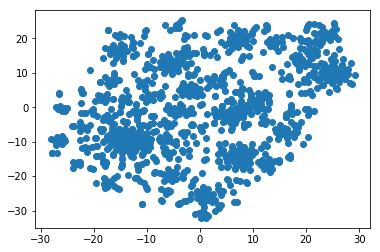

In [9]:
#Visualization results trained word embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize(weights):
    n_sne = 1000
    tsne = TSNE(verbose=1)
    tsne_results = tsne.fit_transform(weights)

    df_tsne = {}
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    %matplotlib inline

    plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'])

visualize(co_occurence[:])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.004s...
[t-SNE] Computed neighbors for 1183 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.109482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.817154
[t-SNE] Error after 1000 iterations: 2.720972


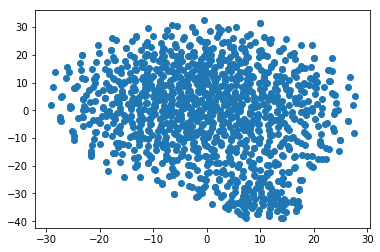

In [10]:
from keras.models import load_model
model = load_model('skipgram_simple.h5')
weights = model.layers[0].get_weights()[0]

visualize(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.003s...
[t-SNE] Computed neighbors for 1183 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.085271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.370628
[t-SNE] Error after 1000 iterations: 2.338613


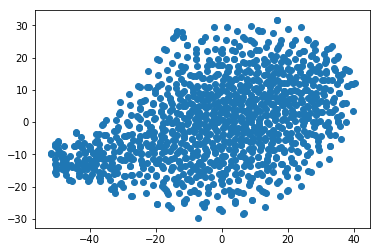

In [11]:
from keras.models import load_model
model = load_model('cbow_simple.h5')
weights = model.layers[0].get_weights()[0]

visualize(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.003s...
[t-SNE] Computed neighbors for 1183 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.085271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.757965
[t-SNE] Error after 1000 iterations: 2.345189


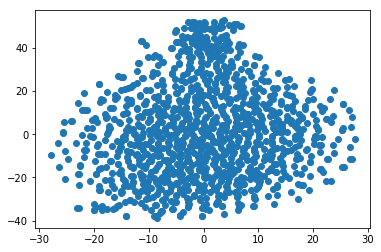

In [12]:
from keras.models import load_model
model = load_model('dcbow_elu.h5')
weights = model.layers[0].get_weights()[0]

visualize(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.004s...
[t-SNE] Computed neighbors for 1183 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.109482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.238083
[t-SNE] Error after 1000 iterations: 2.731842


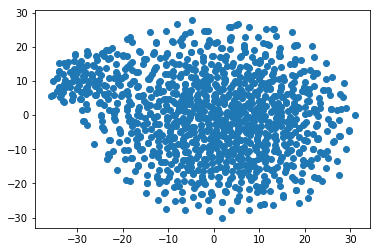

In [13]:
from keras.models import load_model
model = load_model('skipgram_simple.h5')
weights = model.layers[0].get_weights()[0]

visualize(weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1183 samples in 0.004s...
[t-SNE] Computed neighbors for 1183 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1183
[t-SNE] Computed conditional probabilities for sample 1183 / 1183
[t-SNE] Mean sigma: 0.107474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.645760
[t-SNE] Error after 1000 iterations: 2.921335


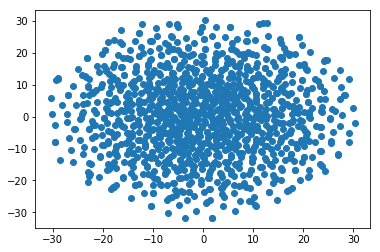

In [14]:
from keras.models import load_model
model = load_model('dskipgram_elu.h5')
weights = model.layers[0].get_weights()[0]

visualize(weights)

gerund
superlative
ly
he/she/it
m/f
past
opposites
plural
One or more words in the corpus were not found ['queen', 'woman', 'king', 'man']
One or more words in the corpus were not found ['boy', 'girl', 'man', 'woman']
[[array(['alice', 'she', 'rabbit', 'he'],
      dtype='<U6'), array([ 10,   3,  62, 110]), 0], [array(['alice', 'her', 'rabbit', 'him'],
      dtype='<U6'), array([ 10,  13,  62, 292]), 1], [array(['alice', 'girl', 'rabbit', 'sir'],
      dtype='<U6'), array([ 10, 421,  62, 499]), 2], [array(['dinah', 'cat', 'alice', 'girl'],
      dtype='<U5'), array([ 86, 266,  10, 421]), 3]]
0
[10  3] 3
1
[10 13] 13
2
[ 10 421] 421
3
[ 86 266] 266


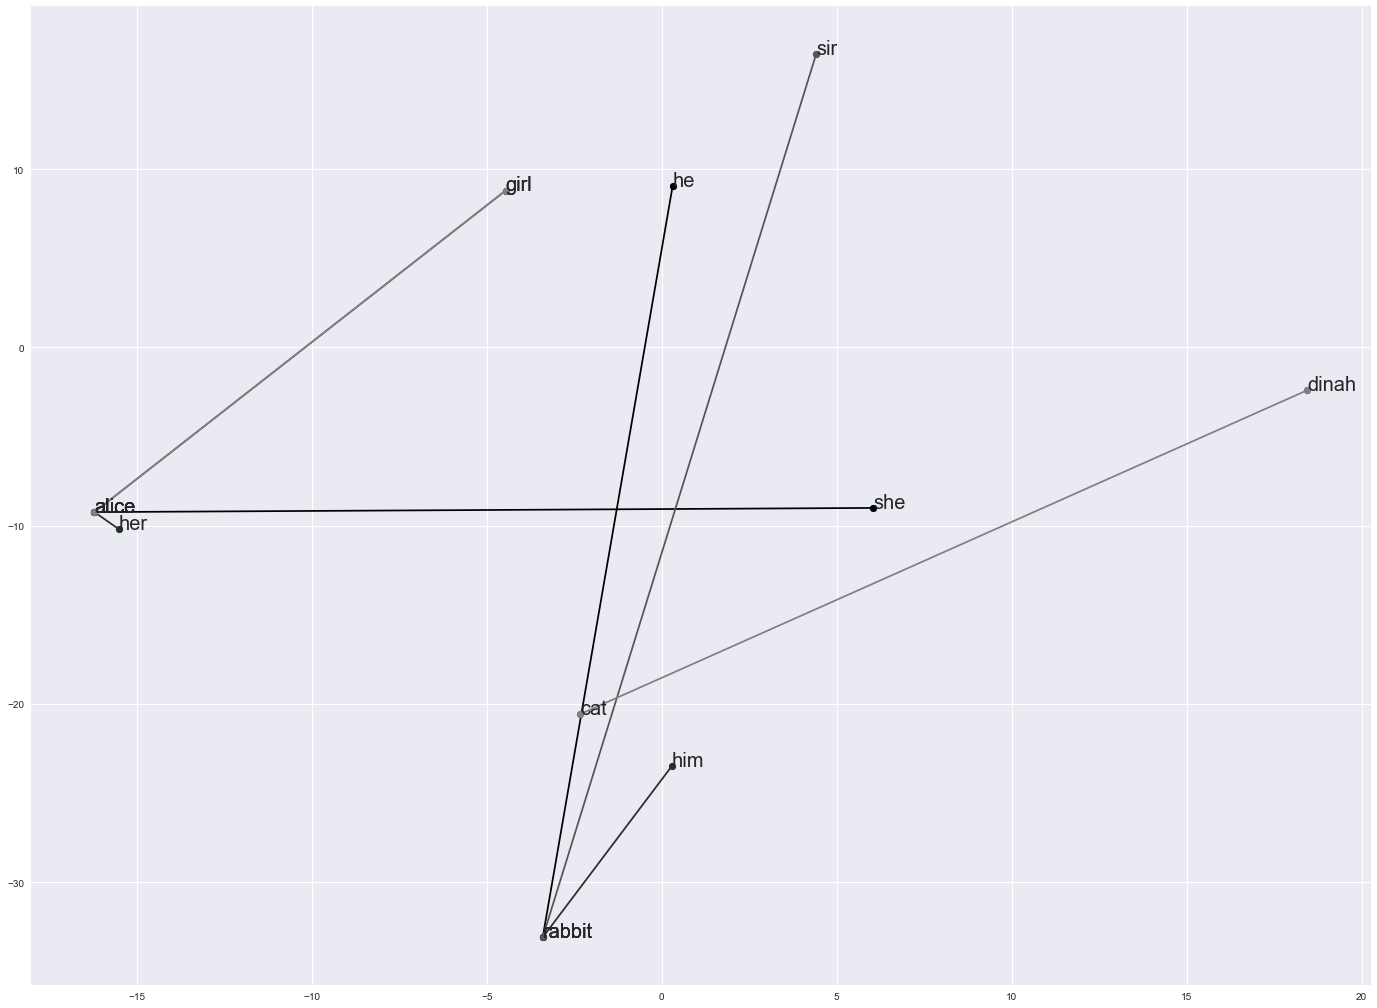

In [20]:
#Visualization results trained word embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Interesting language constructs
sets = {"opposites":[0,12,27,34,44,],
        "superlative":[2,9,10,11,20,21,25,36,37,38],
        "past":[7,13],
        "gerund":[3,6,14,22,23,24,26,39,40,41,42,43],
        "he/she/it":[18,19,35],
        "plural":[8,15,16,17],
        "m/f":[28,29,30,33,45,46],
        "ly":[1,31,32]}

# Copy lines of the sets
for set in sets:
    print(set)
    for i in range(len(sets[set])):
        sets[set][i] = corpus_anal_words[sets[set][i]]
        
def visualize_analogy(weights, corpus_anal_words, tokenizer):
    tsne = TSNE()
    tsne_results = tsne.fit_transform(weights)
    df_tsne = {}
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    
    data = []
    for i, words in enumerate(corpus_anal_words):
        try:
            indices = np.array([tokenizer.word_index[word]-1 for word in words])
            label = i
            data.append([np.array(words), indices, label])
        except:
            print("One or more words in the corpus were not found", words)
            continue
    print(data)
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 24
    fig_size[1] = 18
    plt.rcParams["figure.figsize"] = fig_size
    
    fig, ax = plt.subplots()

    for i, analogy in enumerate(data[:]):
        #print(analogy[2])
        #print(analogy[1][[0,1]], analogy[1][1])
        ax.scatter(df_tsne['x-tsne'][analogy[1]], df_tsne['y-tsne'][analogy[1]])
        ax.plot(df_tsne['x-tsne'][analogy[1][[0,1]]], df_tsne['y-tsne'][analogy[1][[0,1]]], 'o-', color=str(i/len(corpus_anal_words)))
        ax.plot(df_tsne['x-tsne'][analogy[1][[2,3]]], df_tsne['y-tsne'][analogy[1][[2,3]]], 'o-', color=str(i/len(corpus_anal_words)))
        for i, word in enumerate(analogy[0]):
            ax.annotate(word, (df_tsne['x-tsne'][analogy[1]][i],df_tsne['y-tsne'][analogy[1]][i]), size=20)
    
visualize_analogy(co_occurence, sets["m/f"], tokenizer)

One or more words in the corpus were not found ['queen', 'woman', 'king', 'man']
One or more words in the corpus were not found ['boy', 'girl', 'man', 'woman']
[[array(['alice', 'she', 'rabbit', 'he'],
      dtype='<U6'), array([ 10,   3,  62, 110]), 0], [array(['alice', 'her', 'rabbit', 'him'],
      dtype='<U6'), array([ 10,  13,  62, 292]), 1], [array(['alice', 'girl', 'rabbit', 'sir'],
      dtype='<U6'), array([ 10, 421,  62, 499]), 2], [array(['dinah', 'cat', 'alice', 'girl'],
      dtype='<U5'), array([ 86, 266,  10, 421]), 3]]
0
[10  3] 3
1
[10 13] 13
2
[ 10 421] 421
3
[ 86 266] 266


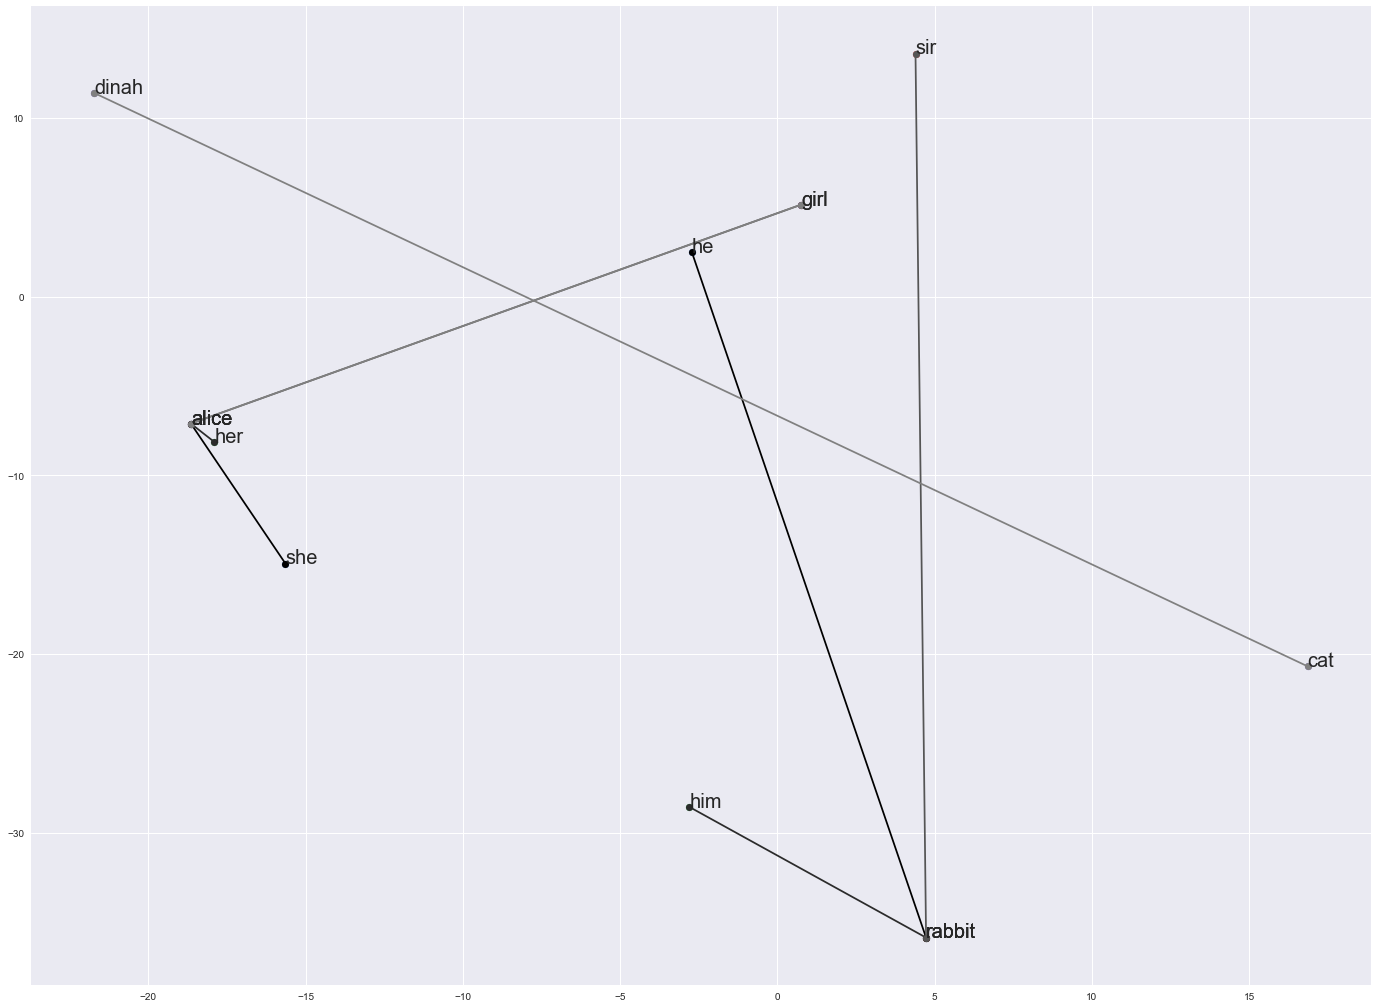

In [16]:
from keras.models import load_model
model = load_model('cbow_simple.h5')
weights = model.layers[0].get_weights()[0]

visualize_analogy(co_occurence, sets["m/f"], tokenizer)

One or more words in the corpus were not found ['queen', 'woman', 'king', 'man']
One or more words in the corpus were not found ['boy', 'girl', 'man', 'woman']
[[array(['alice', 'she', 'rabbit', 'he'],
      dtype='<U6'), array([ 10,   3,  62, 110]), 0], [array(['alice', 'her', 'rabbit', 'him'],
      dtype='<U6'), array([ 10,  13,  62, 292]), 1], [array(['alice', 'girl', 'rabbit', 'sir'],
      dtype='<U6'), array([ 10, 421,  62, 499]), 2], [array(['dinah', 'cat', 'alice', 'girl'],
      dtype='<U5'), array([ 86, 266,  10, 421]), 3]]
0
[10  3] 3
1
[10 13] 13
2
[ 10 421] 421
3
[ 86 266] 266


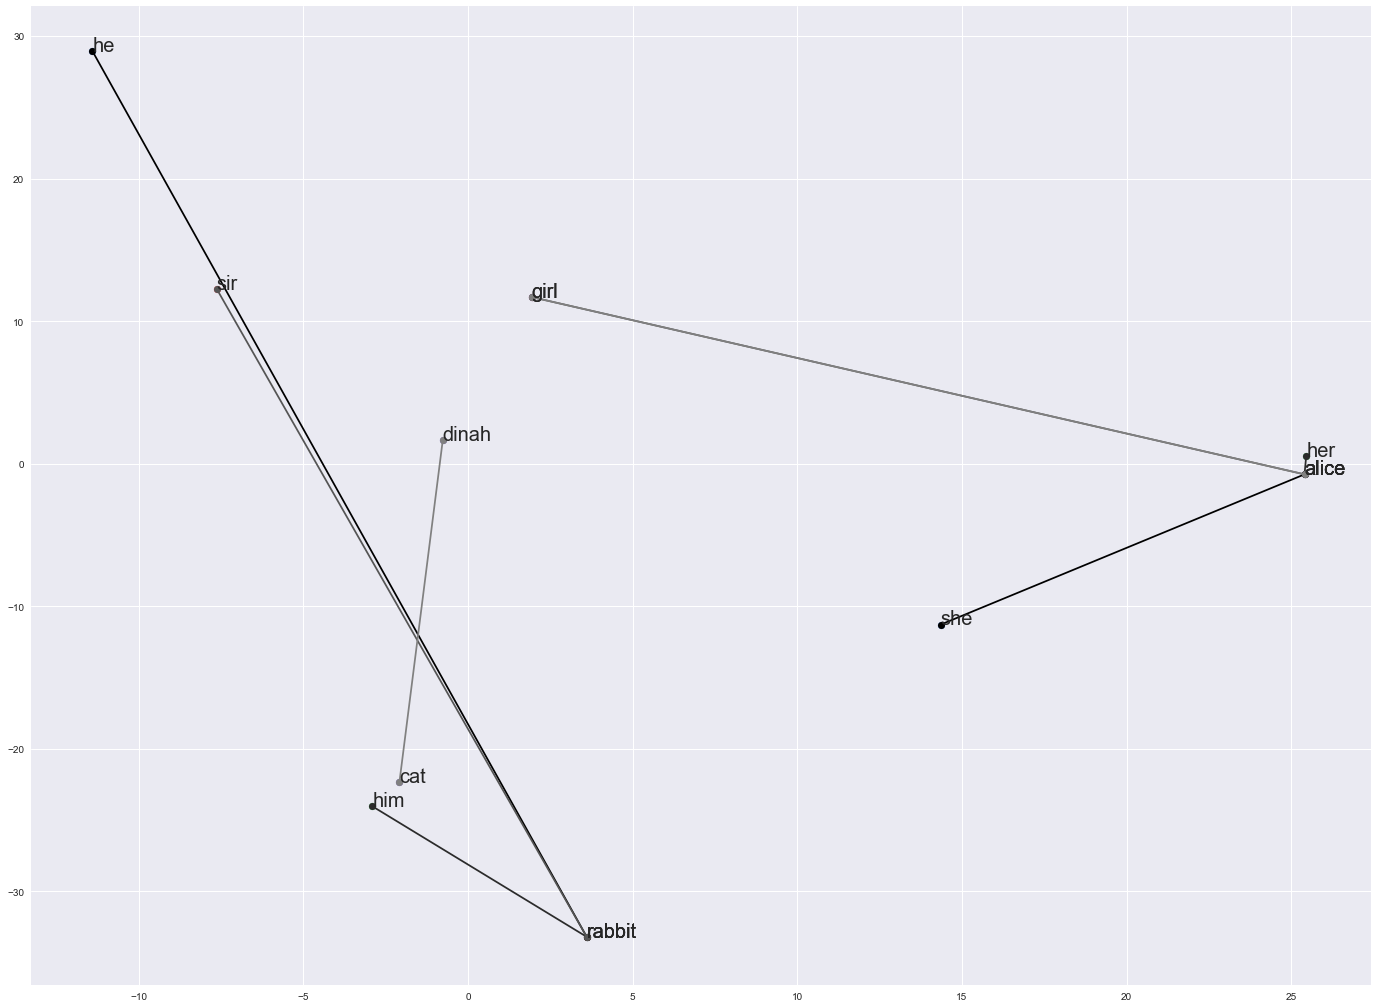

In [17]:
from keras.models import load_model
model = load_model('dcbow_elu.h5')
weights = model.layers[0].get_weights()[0]

visualize_analogy(co_occurence, sets["m/f"], tokenizer)

One or more words in the corpus were not found ['queen', 'woman', 'king', 'man']
One or more words in the corpus were not found ['boy', 'girl', 'man', 'woman']
[[array(['alice', 'she', 'rabbit', 'he'],
      dtype='<U6'), array([ 10,   3,  62, 110]), 0], [array(['alice', 'her', 'rabbit', 'him'],
      dtype='<U6'), array([ 10,  13,  62, 292]), 1], [array(['alice', 'girl', 'rabbit', 'sir'],
      dtype='<U6'), array([ 10, 421,  62, 499]), 2], [array(['dinah', 'cat', 'alice', 'girl'],
      dtype='<U5'), array([ 86, 266,  10, 421]), 3]]
0
[10  3] 3
1
[10 13] 13
2
[ 10 421] 421
3
[ 86 266] 266


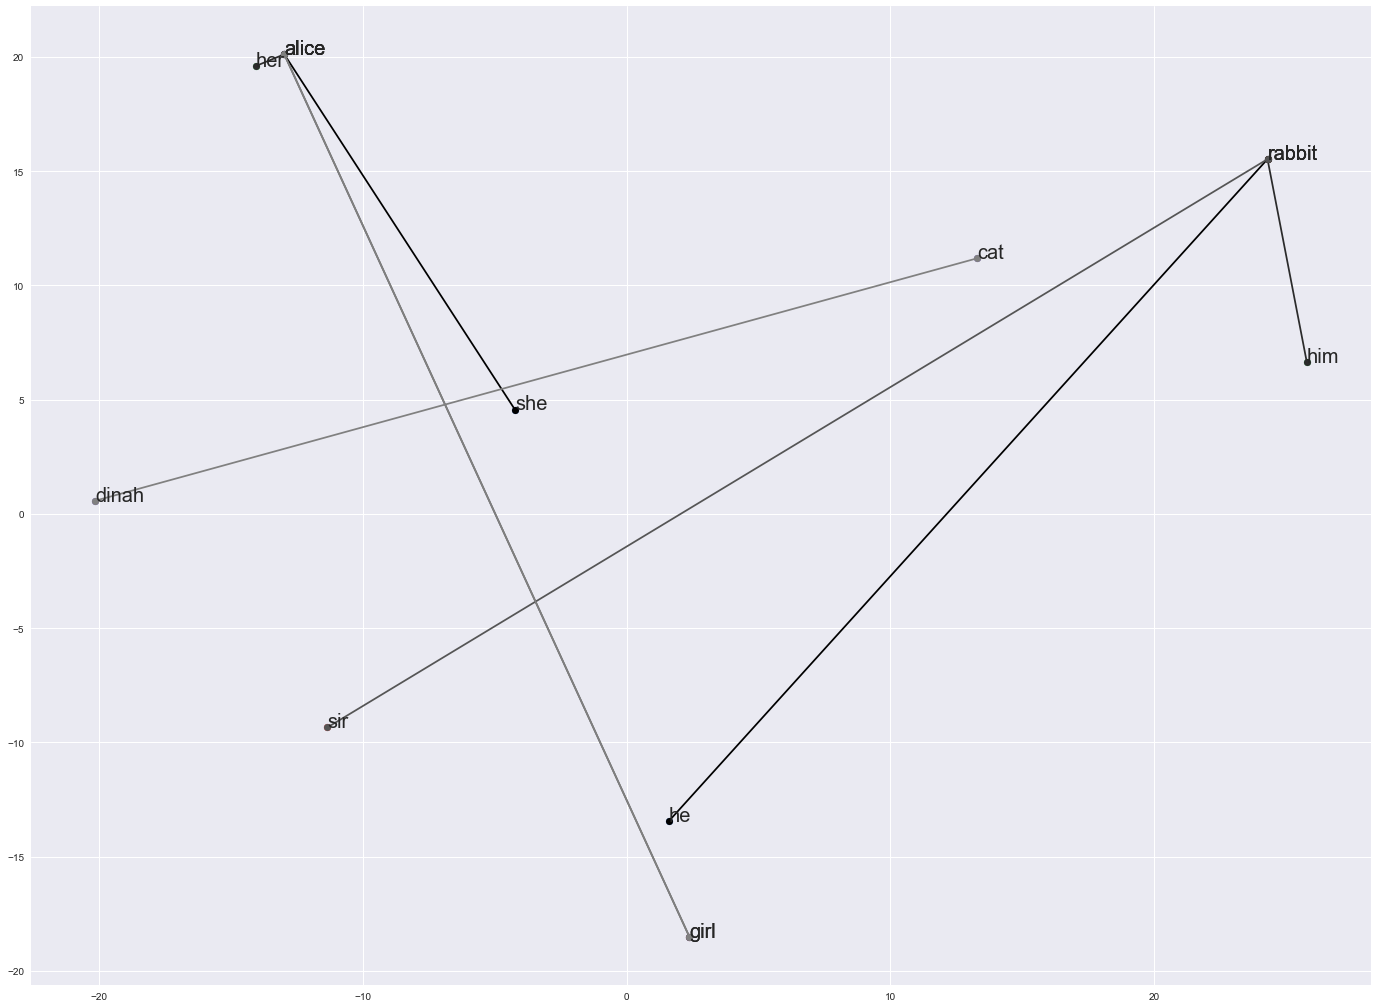

In [18]:
from keras.models import load_model
model = load_model('skipgram_simple.h5')
weights = model.layers[0].get_weights()[0]

visualize_analogy(co_occurence, sets["m/f"], tokenizer)

One or more words in the corpus were not found ['queen', 'woman', 'king', 'man']
One or more words in the corpus were not found ['boy', 'girl', 'man', 'woman']
[[array(['alice', 'she', 'rabbit', 'he'],
      dtype='<U6'), array([ 10,   3,  62, 110]), 0], [array(['alice', 'her', 'rabbit', 'him'],
      dtype='<U6'), array([ 10,  13,  62, 292]), 1], [array(['alice', 'girl', 'rabbit', 'sir'],
      dtype='<U6'), array([ 10, 421,  62, 499]), 2], [array(['dinah', 'cat', 'alice', 'girl'],
      dtype='<U5'), array([ 86, 266,  10, 421]), 3]]
0
[10  3] 3
1
[10 13] 13
2
[ 10 421] 421
3
[ 86 266] 266


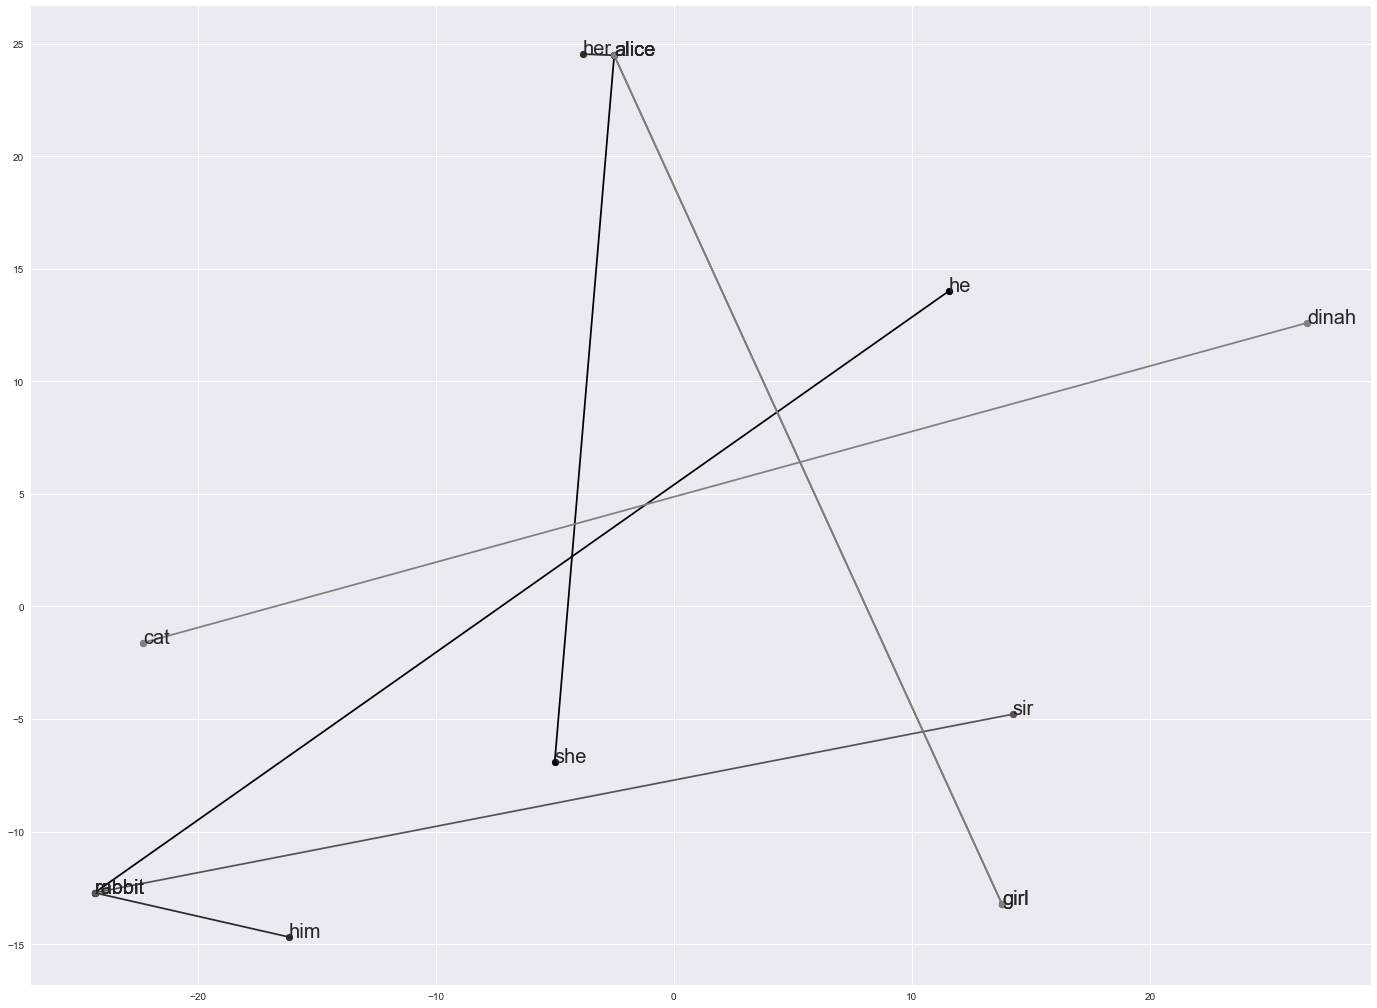

In [19]:
from keras.models import load_model
model = load_model('dskipgram_elu.h5')
weights = model.layers[0].get_weights()[0]

visualize_analogy(co_occurence, sets["m/f"], tokenizer)

### Discussion visualization
When we look at the plot of all the words we see that the co-occurrence shows some clusters. The neural networks on the other hand don't show this pattern. The feature vector is spread out more without those clusters. 

It is interesting to see that although the neural networks don't show the same clusters as the co-occurrence matrix there are two clusters visible in in all neural network representations.

When we look at the analogy visualization we see that the there is no clear pattern visible as we hoped for. Lines look random and don't show clear patterns. This might have to do with the size of the dataset. We think that results would have been better if the model was trained on a larger dataset. The 700 lines is probably to small for the model to get trained.

We looked at different types of language constructs. The sets variable contains the following information:

```
sets = {"opposites":[0,12,27,34,44,],
        "superlative":[2,9,10,11,20,21,25,36,37,38],
        "past":[7,13],
        "gerund":[3,6,14,22,23,24,26,39,40,41,42,43],
        "he/she/it":[18,19,35],
        "plural":[8,15,16,17],
        "m/f":[28,29,30,33,45,46],
        "ly":[1,31,32]}
```
None of these showed any promising results.

## Compare the results of the trained word embeddings with the word-word co-occurrence matrix:

Comparison performance:

In the results above you can see that looking at the the different methods we do find some correlation. It can be seen that there are only two collection of words on which all models agree that they are similar. That are the combinations of ['go', 'going', 'look', 'looking'] and ['listen', 'listening', 'look', 'looking']. What is curious is that in both examples the words look and looking are present. 

Apart from that it is noticable that our own analogy perfoms like the CBOW and Skipgram models with only one dense level. There are some collection of words on which it only agrees with one of the two models or non of the two models. But in general our own analogy agrees more with the one dense function CBOW and Skipgram agree more than compared to the extra dense CBOW and Skipgram model. 

However, it it worth mentioning that the extra dense models tend to agree with eachother meaning that if one evaluates to true the other also evaluates to true. This might be due to the fact that the same activation functions have been used.

Finally it is important to mention that we used hardcoded values to determine whether a collection of words evaluates to true or false within a specific model. It could be improved by using the nearest neighbour of the outcomming vector and compare that to the vector of the word which we expect it to be. We expect this method to result in more reliable results than hardcoding the values.

## Discussion of the advantages of CBOW and Skipgram 

There are different advantages for both CBOW and Skipgram since both methods are the opposite of eachother. Continous bag of words try to predict a word given the context and Skipgram tries to predict the context given a word. 

An advantage of using CBOW is the fact that it is a probabilistic model, which also holds for Skipgram. Probabilistic models hae an advantage over deterministic models since they result in several results. In general they are considered superior to deterministic models. Another advantage of both is that they do not need that much memory compared for example to the co-occurence matrix. 

An advantage CBOW has over Skipgram is the fact that it trains faster as long as it is optimized properly. If it is not optimized correctly it can take a long time to train a CBOW network from scratch, especially with several dense layers. CBOW does performs slightly better for frequently used words in the corpus.

Adavantages of Skipgram compared to CBOW is that Skipgram needs relatively small amount of data for training. Since it only needs some focus words and from these focus words the context. CBOW needs all the context of a word and the word itself. Another advantage is that Skipgram is able to handle two different context types for one word. For example Apple could point to both the company and the fruit. 

## Discussion of the advantages of negative sampling
Negative sampling axproximately maximizes the softmax. A major advantage compared with traditional softmax is that it is faster to compute. It is also faster to train since for each training example only a small percentage of the weights is updated. 

It changes a unsupervised problem in a supervised problem. It tries to distinguish between noise relations and the actual linguistic relations between words. Which is also called noise contrastive estimation . Here we assume that co-occuring words have a linguistic relation.

Negative sampling works well for frequent words.

## Discussion of the drawbacks of CBOW and Skipgram

There are som drawbacks or disadvantages of using CBOW and Skipgram is that they do reduce the number of dimensions of the original training set. It adds dense layers with a specific activation to it. It has to learn which connections should exist between the original words, the hidden layer and the outcome. This training of the model has to happen on a training set of data. Because usually there is a specific topic on which you train it is then hard for the model to predict outcomes on an actual data set which which is not about that specific topic. Also both models do not handle words which consists of two words such as New York quite poorly. It handles it as two different words instead of seeing it as one. 

CBOW has one major advantage which is that it cannot deal very well with words which can have different semantics. Such as the example mentioned when discussing the advantages of Skipgram, the word Apple. It will place Apple in a cluster between the cluster about the company and the cluster about the fruit. Another drawback which was already slightly mentioned is that it can take very long to train a CBOW model from scratch if it is not done properly. 


In [4]:
#load pretrained word embeddings of word2vec

path_word2vec = "data/GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [11]:
import gensim
from gensim.scripts import glove2word2vec
#load pretraind word embeddings of Glove

#path = "data/glove.6B/glove.6B.300d.txt"
filename = 'data/glove.6B/glove.6B.300d.txt'

gensim.scripts.glove2word2vec.glove2word2vec(filename, 'glove.6B/word2vec.glove.300d.txt')
glove = KeyedVectors.load_word2vec_format('data/glove.6B/word2vec.glove.300d.txt', binary=False)

In [ ]:
#Visualize the pre-trained word embeddings

Comparison performance with your own trained word embeddings